In [565]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import itertools

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, SGDClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay

from matplotlib.patches import Patch
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
    )
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader,TensorDataset

In [566]:
def isMyModelGood(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot()

    r2 = r2_score(y_test, y_pred)
    print("r^2:", r2)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE test:", mse)

    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)

    recall = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print(f"Model : Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print('AUC = ',auc(fpr, tpr) )


In [567]:
#Pipeline
df = pd.read_csv('startup_data.csv')
# df.info()

In [568]:
#dropping cols, encoding

cols_to_drop = ['Unnamed: 0', 'Unnamed: 6', 'object_id', 'id', 'state_code.1', 'state_code', 'city', 'latitude', 'longitude', 'zip_code', 'name', 'category_code', 'closed_at', 'labels']
df2 = df.drop(columns=cols_to_drop, errors="ignore")

target = df2.columns[-1]
df2[target] = df2[target].map({'closed': 0, 'acquired': 1})

object_cols = df2.select_dtypes(include=["object"]).columns[:3]

for col in object_cols:
    df2[col] = pd.to_datetime(df2[col], errors="coerce") 
    df2[col] = df2[col].view("int64")

#will be applying scaler to all features except for categorical features

#df2 = pd.get_dummies(df2, columns=['status'], drop_first=True)
df2.info()
#encoding status

# print("cols in df2:", df2.columns.tolist())
# print("impute columns:", impute_cols)
# print("scale columns:", scale_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [569]:
#splitting data

x = df2.iloc[:,0:34]
y = df2['status']

x.info()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=42)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
x_val = x_val.astype(float)

y_train = y_train.astype(float)
y_test = y_test.astype(float)
y_val = y_val.astype(float)

print("class dist.", Counter(y_train))

x_train.info()

#after running mi and moving around the steps, found a bunch of issues with data leakage
#apparently i needed to split before preprocessing, and i was preprocessing the entire data set instead of just the training data which led to huge data leakage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [570]:

impute_cols = ['age_first_milestone_year', 'age_last_milestone_year']

imputer = SimpleImputer(strategy='median')

x_train[impute_cols] = imputer.fit_transform(x_train[impute_cols])
x_val[impute_cols] = imputer.transform(x_val[impute_cols])
x_test[impute_cols] = imputer.transform(x_test[impute_cols])

x_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 590 entries, 812 to 13
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                590 non-null    float64
 1   first_funding_at          590 non-null    float64
 2   last_funding_at           590 non-null    float64
 3   age_first_funding_year    590 non-null    float64
 4   age_last_funding_year     590 non-null    float64
 5   age_first_milestone_year  590 non-null    float64
 6   age_last_milestone_year   590 non-null    float64
 7   relationships             590 non-null    float64
 8   funding_rounds            590 non-null    float64
 9   funding_total_usd         590 non-null    float64
 10  milestones                590 non-null    float64
 11  is_CA                     590 non-null    float64
 12  is_NY                     590 non-null    float64
 13  is_MA                     590 non-null    float64
 14  is_TX         

In [571]:
#outliers
cols_to_check = list(x_train.columns[:11]) + ['avg_participants']

for column in cols_to_check:
    Q1 = x_train[column].quantile(.25)
    Q3 = x_train[column].quantile(.75)
    IQR = Q3-Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    mask =  (x_train[column] >= lower) & (x_train[column] <= upper)
    x_train = x_train[mask]
    y_train = y_train[mask]


print(x_train.describe())

         founded_at  first_funding_at  last_funding_at  \
count  4.410000e+02      4.410000e+02     4.410000e+02   
mean   1.145520e+18      1.204511e+18     1.247683e+18   
std    9.754771e+16      6.905604e+16     6.725735e+16   
min    9.151488e+17      1.033430e+18     1.072915e+18   
25%    1.072915e+18      1.149206e+18     1.197850e+18   
50%    1.154390e+18      1.199146e+18     1.257034e+18   
75%    1.224202e+18      1.260835e+18     1.300925e+18   
max    1.343779e+18      1.384906e+18     1.384906e+18   

       age_first_funding_year  age_last_funding_year  \
count              441.000000             441.000000   
mean                 1.870579               3.239561   
std                  1.868595               2.290567   
min                 -3.506800              -1.986300   
25%                  0.490400               1.465800   
50%                  1.326000               2.879500   
75%                  2.950700               4.676700   
max                  7.537000

In [572]:
# Initialize a list to track removed features
x_with_const = add_constant(x_train) 
removed_features = []

# Set your VIF threshold
threshold = 10

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = x_train.columns
    vif_data["VIF"] = [
        variance_inflation_factor(x_with_const, i + 1) for i in range(x_train.shape[1])
    ]

    # Find the feature with the highest VIF above the threshold
    max_vif = vif_data["VIF"].max()
    if max_vif > threshold:
        feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
        print(f"Removing '{feature_to_remove}' with VIF: {max_vif:.2f}")
        x_train = x_train.drop(columns=[feature_to_remove], errors='ignore')
        x_with_const = add_constant(x_train)  # Recalculate constant after dropping
        removed_features.append(feature_to_remove)
    else:
        break  # Stop if no features exceed the threshold

# Remove the same features from x_test and x_val
x_test = x_test.drop(columns=removed_features, errors='ignore')
x_val = x_val.drop(columns=removed_features, errors='ignore')

print("Removed features:", removed_features)

Removing 'age_last_funding_year' with VIF: 6407684822.25
Removing 'age_first_funding_year' with VIF: 4478651300.30
Removed features: ['age_last_funding_year', 'age_first_funding_year']


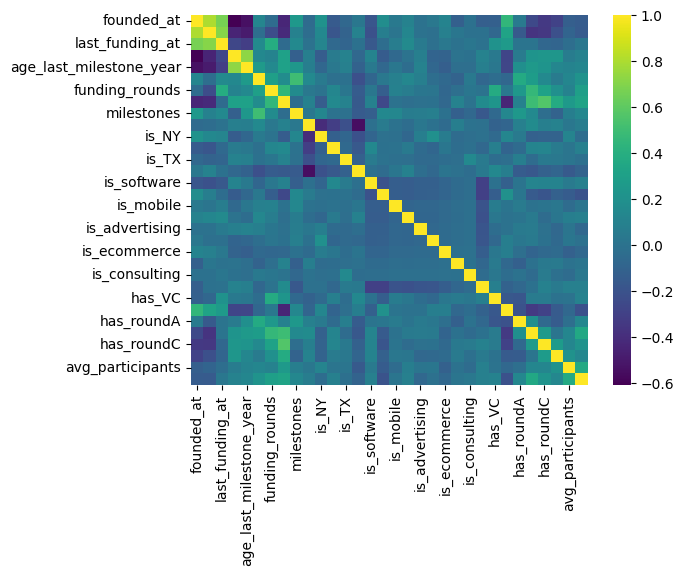

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 788 to 13
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                441 non-null    float64
 1   last_funding_at           441 non-null    float64
 2   age_first_milestone_year  441 non-null    float64
 3   age_last_milestone_year   441 non-null    float64
 4   relationships             441 non-null    float64
 5   funding_rounds            441 non-null    float64
 6   funding_total_usd         441 non-null    float64
 7   milestones                441 non-null    float64
 8   is_CA                     441 non-null    float64
 9   is_NY                     441 non-null    float64
 10  is_MA                     441 non-null    float64
 11  is_TX                     441 non-null    float64
 12  is_otherstate             441 non-null    float64
 13  is_software               441 non-null    float64
 14  is_web        

In [573]:


#dropping columns with a high corr
threshold = .8
corr_matrix = x_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap="viridis")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [
    column for column in upper.columns if any(upper[column] > threshold)
]

x_train = x_train.drop(columns=high_corr_features, errors='ignore')
x_test = x_test.drop(columns=high_corr_features, errors='ignore')
x_val = x_val.drop(columns=high_corr_features, errors='ignore')

x_train.info()

print(high_corr_features)

In [574]:
#mi to deal with multicolinearity on things like is_ma, is_ny, is_ca, etc
mi = mutual_info_classif(x_train, y_train, random_state = 21)
mi_scores = pd.Series(mi, index=x_train.columns).sort_values(ascending=False)
print(mi_scores)
top_features = mi_scores[mi_scores >0.01].index

x_train = x_train[top_features]
x_test = x_test[top_features]
x_val = x_val[top_features]

# class_distribution = Counter(y_test)
# print("Class distribution in y_test:", class_distribution)


# print(x_train.head())

# most models did worse with mi, not sure why but i think its better to keep mi
# commented it out mi and tried again, results were still worse than before mi
# i think its how i moved the data organization and pipeline

relationships               0.155721
age_last_milestone_year     0.124261
age_first_milestone_year    0.119939
milestones                  0.064132
avg_participants            0.060607
funding_total_usd           0.058371
is_top500                   0.048504
has_roundB                  0.045227
has_roundA                  0.034231
is_MA                       0.030718
funding_rounds              0.026214
is_othercategory            0.021053
has_roundC                  0.020223
is_software                 0.020145
is_NY                       0.020123
is_otherstate               0.017032
is_enterprise               0.014384
is_web                      0.010456
has_VC                      0.004850
is_biotech                  0.004723
is_advertising              0.001680
last_funding_at             0.000000
founded_at                  0.000000
is_TX                       0.000000
is_CA                       0.000000
is_mobile                   0.000000
is_gamesvideo               0.000000
i

In [575]:
#SMOTE to oversample minority class since imbalance is screwing with pred
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

print("class dist. after SMOTE: ", Counter(y_train))

class dist. after SMOTE:  Counter({1.0: 271, 0.0: 271})


In [576]:
x_train.info()
scale_cols = [
    'relationships', 
    'age_last_milestone_year', 
    'age_first_milestone_year', 
    'milestones', 
    'avg_participants', 
    'funding_total_usd', 
    'funding_rounds'
]
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])
x_val[scale_cols] = scaler.transform(x_val[scale_cols])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   relationships             542 non-null    float64
 1   age_last_milestone_year   542 non-null    float64
 2   age_first_milestone_year  542 non-null    float64
 3   milestones                542 non-null    float64
 4   avg_participants          542 non-null    float64
 5   funding_total_usd         542 non-null    float64
 6   is_top500                 542 non-null    float64
 7   has_roundB                542 non-null    float64
 8   has_roundA                542 non-null    float64
 9   is_MA                     542 non-null    float64
 10  funding_rounds            542 non-null    float64
 11  is_othercategory          542 non-null    float64
 12  has_roundC                542 non-null    float64
 13  is_software               542 non-null    float64
 14  is_NY     

AUC =  0.6631821884333424


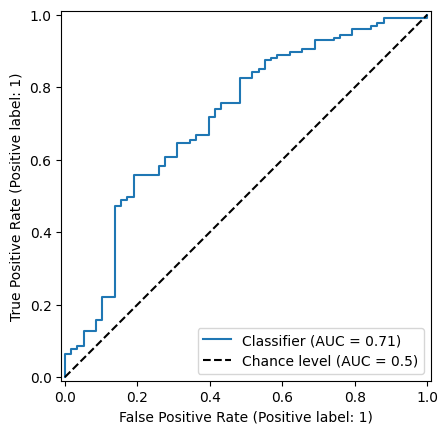

In [577]:
clf = LogisticRegression(random_state=42)
clf.fit(x_train, y_train)
#print("model score: %.3f" % clf.score(x_val, y_val))  # average accuracy

y_pred=clf.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print('AUC = ',auc(fpr, tpr) )
prob=clf.predict_proba(x_test)[:,1]
RocCurveDisplay.from_predictions(y_test, prob,plot_chance_level=True)
plt.show()




r^2: -0.4315775183274506
MSE test: 0.3081081081081081
Model : Accuracy=0.692, Precision=0.797, Recall=0.740, F1=0.767
AUC =  0.6631821884333424
r^2 train: 0.047970479704797064
MSE train: 0.23800738007380073


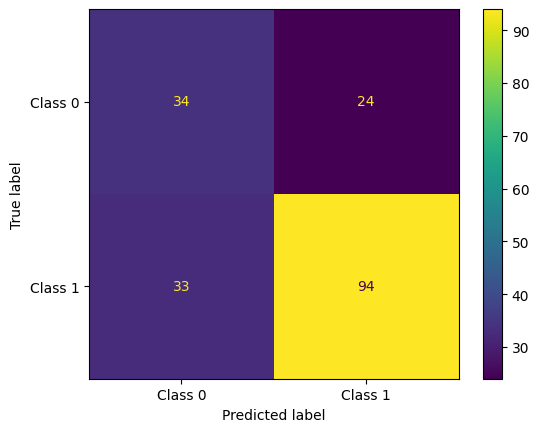

In [578]:
isMyModelGood(y_test, y_pred)
y_train_pred = clf.predict(x_train)

r22 = r2_score(y_train, y_train_pred)
print("r^2 train:", r22)
#both r2 worse than baseline


mse2 = mean_squared_error(y_train, y_train_pred)
print("MSE train:", mse2)
#mse test also worse than baseline, but not by as much like with r2

#gonna test this with more models n see now

In [579]:
y_baseline = [y_train.mean()] * len(y_test)

# MSE for the baseline
baseline_mse = mean_squared_error(y_test, y_baseline)
print("Baseline MSE:", baseline_mse)

Baseline MSE: 0.25


In [580]:
#perceptron-adaline
class Adaline:
    def __init__(self, lr=0.01, n_epoch=150):
        self.lr = lr
        self.n_epoch = n_epoch
        self.weight = None
        self.bias = None
    
    #computing weighted sum of inputs and adding bias
    def __func__(self, x):
        return np.dot(x, self.weight) + self.bias
    
    #updating weight and biases for each epoch and gets predictions
    #in each epoch computes output, finds error, computes gradient of loss (mse) and updates weights and biases
    def fit(self, x, y):
        self.weight=np.zeros(x.shape[1])
        self.bias=0

        for _ in range(self.n_epoch):
            output=self.__func__(x)
            error = output-y
            dw = 2*np.dot(error, x)/x.shape[0]
            db = 2*error.mean()

            self.weight = self.weight-self.lr*dw
            self.bias-=self.lr*db
    
    #now we use the model
    def predict(self, x):
        return np.where(self.__func__(x)>=.5, 1,0)


r^2: -0.4818083084442033
MSE test: 0.31891891891891894
Model : Accuracy=0.681, Precision=0.788, Recall=0.732, F1=0.759
AUC =  0.6506244909041542


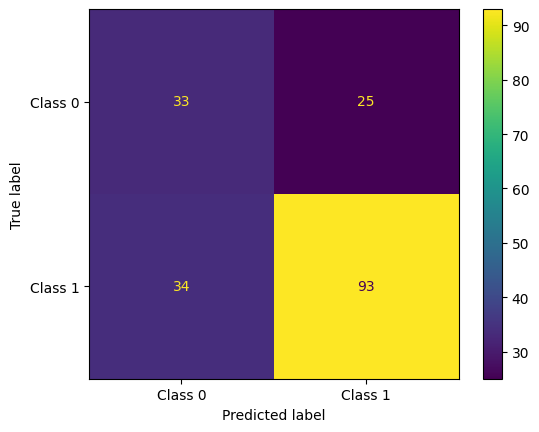

In [581]:
ada = Adaline()
ada.fit(x_train, y_train)

y_pred=ada.predict(x_test)

isMyModelGood(y_test, y_pred)
#this is even worse than logistic regresion broooooooo
#also the r2 and mse are exactly the same however the cm is different so idk if this is just a coincidence
#these are both linear models, which might be too simple, the data doesnt look linearly separable, which means linear models wont work well here

#okay actually disregard the above comments i was stupid and forget to pipeline the data before running the model
#its actually somewhat better than LR, but still lacking.
#small improvements are improvements

In [582]:
#custom logistic regression
#cuz the first time was mainly for testing my model

def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogRegSimple():
    def __init__(self, lr=0.1, n_epoch=100):
        self.lr=lr
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    #forward calculates logits (raw score for the sigmoid function)
    #forward = forward pass (duh)
    def forward(self, x):
        return sigmoid(np.dot(x, self.weights)+self.bias)
    
    # fit initializes weights and biases, then for each epoch it makes a prediction and calculates loss, then calculates bias and weights
    def fit(self, x, y):
        self.weights=np.zeros(x.shape[1])
        #had to change from self.weights = np.array([0, 0]) since this doesnt update according to x passed
        self.bias=0

        for epoch in range(self.n_epoch):
            y_pred = self.forward(x)
            loss = (np.dot(-y, np.log(y_pred))-np.dot(1-y, np.log(1-y_pred)))/x.shape[0]

            #note to self --> these are the gradient updates
            self.weights = self.weights+self.lr*np.dot(x.T, y-y_pred)/x.shape[0]
            self.bias+=self.lr*(y-y_pred).mean()

        return self
    
    def predict(self, x):
        return self.forward(x).round()
    def param(self):
        return self.weights, self.bias

r^2: -0.4818083084442033
MSE test: 0.31891891891891894
Model : Accuracy=0.681, Precision=0.779, Recall=0.748, F1=0.763
AUC =  0.6412571273418409


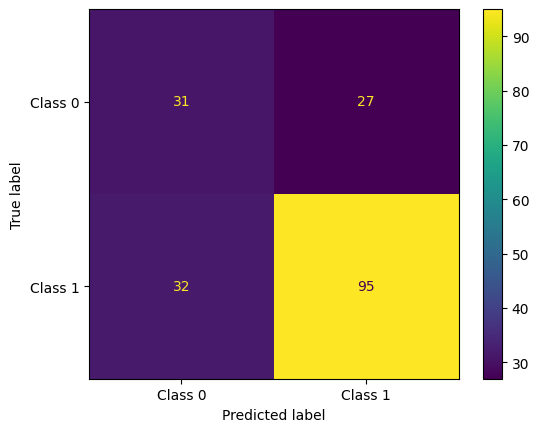

In [583]:

logreg = LogRegSimple(lr=0.1,n_epoch=200)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)


isMyModelGood(y_test, y_pred)

#better in some aspects, worse in others, but better than the library included logreg, prob because of the params i passed
#r2 and mse still trash tho

In [584]:
#svm

class SVM:
    def __init__(self, lr = .01, lambda_param=0.01, n_epoch = 1000):
        self.lr = lr
        self.lambda_param=lambda_param
        self.n_epoch=n_epoch
        self.weights=None
        self.bias=None

    #just in general, fit optimizes weights and bias of models
    #here it uses a hinge loss function w gradient descent
    def fit(self, x, y):
        n_samples, n_features = x.shape

        #just recodes labels, turning -1 to 1
        yc = np.where(y <=0, -1, 1)

        self.weights = np.zeros(n_features)
        self.bias=0

        #training loop
        for _ in range(self.n_epoch):
            #updates weights and bias for each training sample
            for idx, x_i in enumerate(x):
                condition = yc[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    #here, if the sample is classified correctly 0 loss
                    self.weights -= self.lr*(2*self.lambda_param*self.weights)
                else:
                    #otherwise hinge loss gradient will be applied (and regularization term)
                    self.weights -= self.lr*(2*self.lambda_param*self.weights-np.dot(x_i, yc[idx]))
                    self.bias-=self.lr*yc[idx]
    
    def predict(self, x):
        approx = np.dot(x, self.weights) - self.bias
        #return np.sign(approx)
        #needs to be removed since getting 3 labels, need to be binary for metrics
        return np.where(approx >=0, 1, 0)

r^2: -0.3562313331523217
MSE test: 0.2918918918918919
Model : Accuracy=0.708, Precision=0.783, Recall=0.795, F1=0.789
AUC =  0.6562584849307629


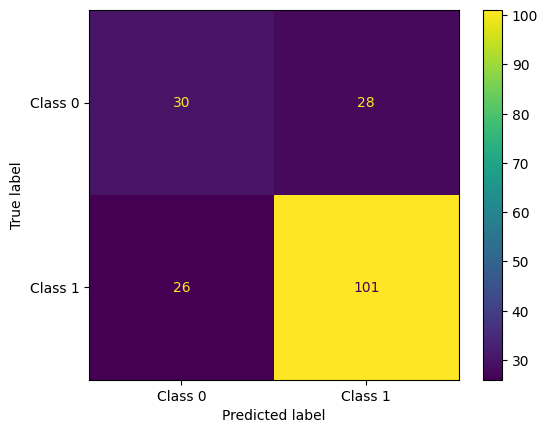

In [585]:
# svm = SVM(lr=.01, lambda_param=.01, n_epoch=1000)
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

isMyModelGood(y_test, y_pred)

#worse than the other two, prob because its also a linear model

r^2: -0.5822698886777085
MSE test: 0.34054054054054056
Model : Accuracy=0.659, Precision=0.786, Recall=0.693, F1=0.736
AUC =  0.639560141189248


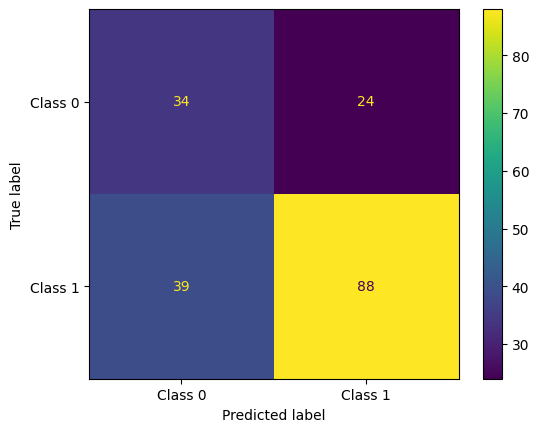

In [586]:
#decision tree
tree = DecisionTreeClassifier(criterion='entropy')

tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

isMyModelGood(y_test, y_pred)

#not great but rf should improve on this at least

r^2: -0.20553896280206363
MSE test: 0.2594594594594595
Model : Accuracy=0.741, Precision=0.788, Recall=0.850, F1=0.818
AUC =  0.6751968503937008


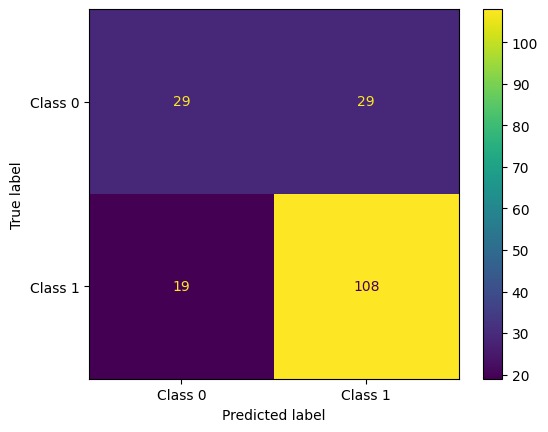

In [587]:
#rf
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=27, class_weight='balanced')
#here i didnt need to use pipeline since rf doesnt compare features against each other but its here for consistencey
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

isMyModelGood(y_test, y_pred)

#a lot better than the others
#r2 is finally positive, and mse is lower, metrics are also higher across the board


In [588]:
#cross validation

sss = StratifiedShuffleSplit(n_splits = 5, test_size = .2, random_state=42)
#originally ran this without sss, got more variable results, this def helped

scores=cross_val_score(rf, x_train, y_train, cv=sss)
print(scores)
#wow, that actually varies a lot
print("%0.2f acc with sd of %0.2f" %(scores.mean(), scores.std()))
#was originally gonna skip over the cv but not after seeing how much is varies

fscores=cross_val_score(rf, x_train, y_train, cv=sss,scoring='f1_macro')
print("%0.2f f1-score with a standard deviation of %0.2f" % (fscores.mean(), fscores.std()))

[0.80733945 0.80733945 0.74311927 0.78899083 0.78899083]
0.79 acc with sd of 0.02
0.79 f1-score with a standard deviation of 0.02


r^2: -0.20553896280206363
MSE test: 0.2594594594594595
Model : Accuracy=0.741, Precision=0.788, Recall=0.850, F1=0.818
AUC =  0.6751968503937008


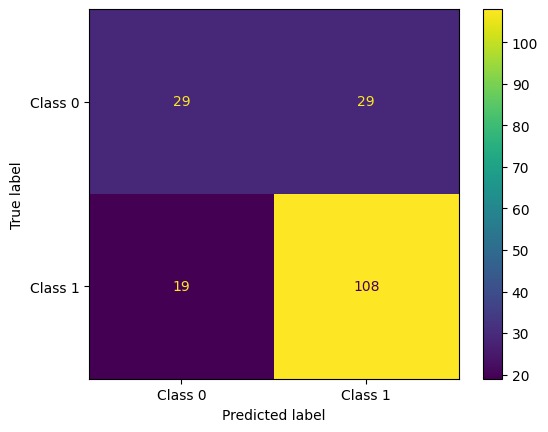

In [589]:
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

isMyModelGood(y_test, y_pred)



In [590]:
#hyper param tuning
#grid search

param_dist = {
    'ccp_alpha': [0.1, 0.01, .001],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
tree_cv = GridSearchCV(dt, param_dist, cv=5)

tree_cv.fit(x_train, y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 6}
Best score is 0.7566428814135235


In [591]:
models_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ]

model_hyper = {
    'logreg_hyper':{
        'C': [0.01, 0.1, 1, 5, 10, 20],  # Regularization strength (smaller = stronger)
        #'penalty': ['l1', 'l2', 'elasticnet', None],  # Type of regularization
        'solver': ['liblinear', 'saga', 'lbfgs'],  # Solver used in optimization
        'max_iter': [100, 200, 500, 1000]  # Maximum iterations for convergence
    },
    'dt_hyper': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [None, 10, 20, 50, 100],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['sqrt', 'log2', None],
        'splitter': ['best', 'random']
    },
    'rf_hyper': {
        'n_estimators': [50, 100, 200, 300, 500],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [None, 10, 20, 50, 100],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
}

model_keys = list(model_hyper.keys())

In [592]:
def ModelSelection(models_list, hyper_dict, x_train, y_train, model_keys, cv_type="gs"):
    result = []
    i = 0

    for model in models_list:
        key = model_keys[i]
        params = hyper_dict[key]
        i+=1

        print(model)
        print(params)
        print('---------------------------------')

        if cv_type=="random":
            classifier=RandomizedSearchCV(model, params, cv=5)
        elif cv_type=="gs":
            classifier = GridSearchCV(model, params, cv=5)
        elif cv_type == "bayes":
            classifier = BayesSearchCV(model, params, n_iter=10, cv=5)

        classifier.fit(x_train, y_train)

        result.append({
            'model used': model,
            'highest score': classifier.best_score_,
            'best hyperparams': classifier.best_params_
        })

    result_dataframe = pd.DataFrame(result, columns = ['model used','highest score','best hyperparams'])

    return result_dataframe


In [593]:
'''rand = ModelSelection(models_list, model_hyper, x_train, y_train, model_keys, cv_type='random')
bayes = ModelSelection(models_list, model_hyper, x_train, y_train, model_keys, cv_type='bayes')
'''
#i will NOT be using gridsearch, i tried it and it ran for 30m and still needed more time

"rand = ModelSelection(models_list, model_hyper, x_train, y_train, model_keys, cv_type='random')\nbayes = ModelSelection(models_list, model_hyper, x_train, y_train, model_keys, cv_type='bayes')\n"

In [594]:
# print("random: ", rand[['model used', 'highest score', 'best hyperparams']])
# print("bayes: ", bayes[['model used', 'highest score', 'best hyperparams']])

'''print(bayes.to_string())'''

'print(bayes.to_string())'

r^2: -0.15530817268531094
MSE test: 0.24864864864864866
Model : Accuracy=0.751, Precision=0.791, Recall=0.866, F1=0.827
AUC =  0.6830708661417323


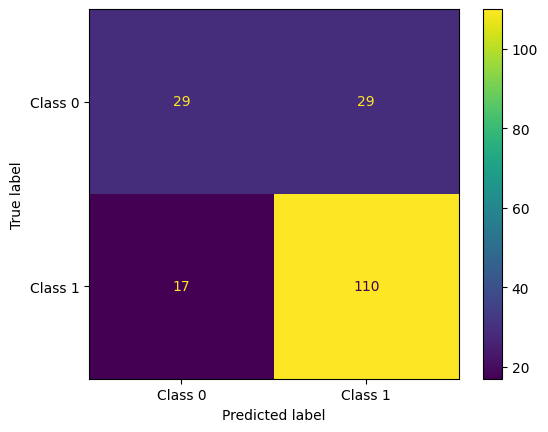

In [595]:
#best model at this pointno 
params = {
    'bootstrap': False, 
    'class_weight': 'balanced', 
    'criterion': 'log_loss', 
    'max_depth': 100, 'max_features': 'sqrt', 
    'min_samples_leaf': 2, 
    'min_samples_split': 5, 
    'n_estimators': 50
}

best_rf = RandomForestClassifier(**params)
best_rf.fit(x_train, y_train)

y_pred = best_rf.predict(x_test)

isMyModelGood(y_test, y_pred)
#honestly isnt that much better and still worse than guessing mean...

In [596]:
#knn

param_dist = {
    'n_neighbors': np.arange(1, 20, 1),
    'metric': ['l1', 'l2', 'cosine']
}

model = KNeighborsClassifier()
tree_cv = GridSearchCV(model, param_dist, cv=5)
tree_cv.fit(x_train, y_train)

print("tuned knn params: {}".format(tree_cv.best_params_))
print("best score is {}".format(tree_cv.best_score_))


tuned knn params: {'metric': 'l1', 'n_neighbors': np.int64(1)}
best score is 0.7749065579340809


r^2: -0.5571544936193322
MSE test: 0.33513513513513515
Model : Accuracy=0.665, Precision=0.793, Recall=0.693, F1=0.739
AUC =  0.6481808308444204


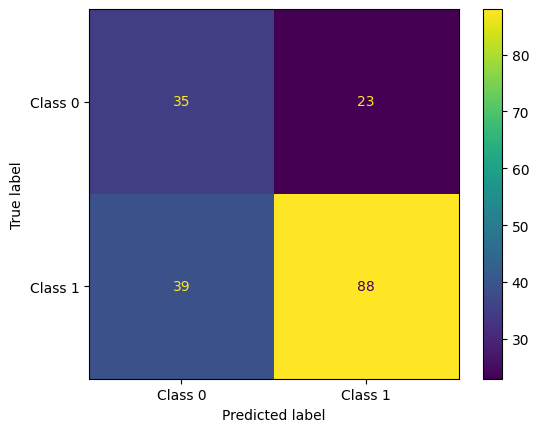

In [597]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
isMyModelGood(y_test, y_pred)

#still not good

r^2: -0.4818083084442033
MSE test: 0.31891891891891894
Model : Accuracy=0.681, Precision=0.804, Recall=0.709, F1=0.753
AUC =  0.6646755362476242


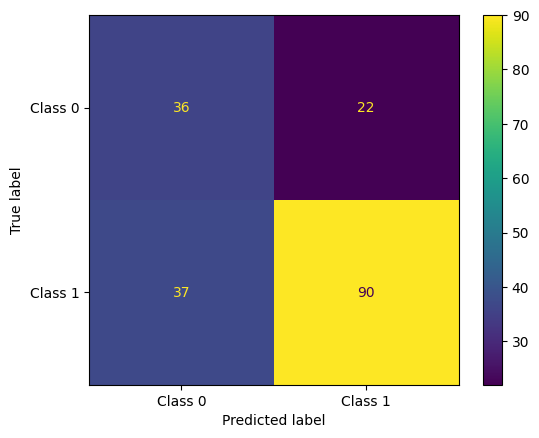

In [598]:
#using rbf, rbf kernel measures similarity between two points based on dist
def metric_rbf(x, y):
    return 1-np.exp(-1*np.linalg.norm(x-y)**2/2)

knn_rbf = KNeighborsClassifier(n_neighbors=1, metric=metric_rbf)
knn_rbf.fit(x_train, y_train)

y_pred = knn_rbf.predict(x_test)
isMyModelGood(y_test, y_pred)

#pretty bad all across the board, i think this is the worst model by far

In [599]:
#pca for dim reduction
'''pca = PCA(n_components = 8)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_val = pca.transform(x_val)'''


'pca = PCA(n_components = 8)\nx_train = pca.fit_transform(x_train)\nx_test = pca.transform(x_test)\nx_val = pca.transform(x_val)'

In [600]:
'''best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)

isMyModelGood(y_test, y_pred)'''

#does worse, likely going to not use pca moving forward

'best_rf.fit(x_train, y_train)\ny_pred = best_rf.predict(x_test)\n\nisMyModelGood(y_test, y_pred)'

In [649]:
#converting to tensors, note to self tensors are just matrices compatable with gpus/cpus (pytorch)
x_train_pt = torch.from_numpy(x_train.values).float()
y_train_pt = torch.from_numpy(y_train.values)
x_test_pt = torch.from_numpy(x_test.values).float()
y_test_pt = torch.from_numpy(y_test.values)
x_val_pt = torch.from_numpy(x_val.values).float()
y_val_pt = torch.from_numpy(y_val.values).float()

#tensor dataset bombines x and y train into tensors, dataset wrapper
train_ds = TensorDataset(x_train_pt, y_train_pt)
test_ds = TensorDataset(x_test_pt, y_test_pt)
val_ds = TensorDataset(x_val_pt, y_val_pt)

batch_size = 20
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

n_samples, n_features = x_train_pt.shape
lr = 0.01
n_epoch = 1000

In [650]:
class MultiClassLogisticRegression(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out
    
model = MultiClassLogisticRegression(num_features= n_features, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
lossfun = nn.CrossEntropyLoss()

In [651]:
for epoch in range(n_epoch):
    model.train()
    for x_batch, y_batch in train_dl:
        #computing outputs
        probas = model(x_batch)

        #computing gradients
        loss = lossfun(probas, y_batch.long())
        optimizer.zero_grad()
        loss.backward()

        #updating wt
        optimizer.step()

    if (epoch+1)%100 == 0:
        model.eval()
        with torch.inference_mode():
            correct = 0
            total = 0

            outputs = nn.functional.softmax(model(x_test_pt), dim=1)
            _, predicted = torch.max(outputs.data, 1)

            total += y_test_pt.size(0)
            correct += (predicted == y_test_pt).sum().item()
            print(f'Epoch [{epoch}/{n_epoch}], Loss: {loss.item():.4f}, Test Acc: {100*correct/total:.2f}')


Epoch [99/1000], Loss: 0.5598, Test Acc: 68.65
Epoch [199/1000], Loss: 0.0566, Test Acc: 67.57
Epoch [299/1000], Loss: 0.5399, Test Acc: 67.03
Epoch [399/1000], Loss: 0.7179, Test Acc: 69.19
Epoch [499/1000], Loss: 0.0946, Test Acc: 67.57
Epoch [599/1000], Loss: 0.9948, Test Acc: 69.19
Epoch [699/1000], Loss: 0.4421, Test Acc: 67.57
Epoch [799/1000], Loss: 0.7548, Test Acc: 68.65
Epoch [899/1000], Loss: 0.3939, Test Acc: 68.65
Epoch [999/1000], Loss: 0.3863, Test Acc: 69.19


In [652]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


print("\nOptimizer's state_dict: " )
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
linear.weight 	 torch.Size([2, 18])
linear.bias 	 torch.Size([2])

Optimizer's state_dict: 
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [653]:
torch.save(model.state_dict(), '.\modelsavesample.pth')

In [654]:
model = MultiClassLogisticRegression(num_features=n_features, num_classes=2)
model.load_state_dict(torch.load('modelsavesample.pth'))
model.eval()

MultiClassLogisticRegression(
  (linear): Linear(in_features=18, out_features=2, bias=True)
)

In [655]:
with torch.inference_mode():
    outputs = model(x_test_pt)
    _, predicted = torch.max(outputs.data, 1)
    correct+=(predicted == y_test).sum().item()
    total+=y_test_pt.size(0)
    print(f'Test Acc: {100 * correct / total:.2f}')

Test Acc: 34.59


In [656]:
#note to self- you pass in the x input and activation functions dictate different ways you can get an output
#graidents are derivs of the activation functions and determine how much the weights 
#for stuff like relu, gradient would be 0 which is why leaky relu is made
#and with certain activation function thi can lead to vanishing gradient which is when the gradients are multiplied but since its very small they converge to 0

In [701]:
n_samples, n_features = x_train.shape
n_hidden = 64
lr = .01
n_epoch = 200

In [702]:
class mlp(torch.nn.Module):
    def __init__(self, num_features, n_hidden, num_classes):
        super(mlp, self).__init__()
        #linear1 creates the first fully connected layer of my mlp
        #and to clarify a connected layer is the steps in between the intial input and final output
        #its the transformations in between
        #so a linear transformation uses the basic weights and biases, but a non linear is what uses the activation function and makes for more complex (nonlinear) relationships
        self.linear1 = torch.nn.Linear(num_features, n_hidden)
        self.relu = nn.ReLU()
        self.linear2 = torch.nn.Linear(n_hidden, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        #dropout is to prevent overfitting by reducing how much a specific neuron can contribute to a prediction so that all neurons can contribute equally

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out
        #more notes for myself:
        #the reason it goes linear, nonlinear, linear is because thats how to format a basic nn, like a sandwich
        #if it were just two linears, that would be equivalent to just one linear, and these capture basic linear relations, which isnt enough and why activation function are needed

model2 = mlp(num_features=n_features, n_hidden = n_hidden, num_classes = 2)
#the optimizer helps adjust params (wts and bias) to reduce error, and sgd is used here
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
lossfunc=nn.CrossEntropyLoss()

In [703]:
# print(Counter(y_train_pt.numpy()))  # For example, in PyTorch
# print(x_train_pt.mean(dim=0))
# print(x_train.describe())


In [704]:
for epoch in range(n_epoch):
    model2.train()
    #with this loop, it does loss, adjusts weights and bias with optimizer, and does this for every batch
    #outter loop repeats this for each epoch to increase accuracy
    for x_batch, y_batch in train_dl:
    #doing outputs again, this is just writing the learning part, when its iterating over itself
        probas = model2(x_batch)

        #gradients
        loss = lossfunc(probas, y_batch.long())
        optimizer.zero_grad()
        loss.backward()

        # print(f"Epoch {epoch + 1}/{n_epoch}, Batch Gradients:")
        # for name, param in model2.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: Gradient mean = {param.grad.abs().mean().item():.6f}")

        optimizer.step()

    model2.eval()
    if(epoch)%10==9:
        with torch.inference_mode():
            correct = 0
            total = 0

            outputs = nn.functional.softmax(model2(x_test_pt), dim = 1)
            _, predicted = torch.max(outputs.data, 1)
            # print("Predicted Labels:", predicted.numpy())
            # print('true labels: ', y_test_pt.numpy())

            total += y_test_pt.size(0)
            correct += (predicted == y_test_pt).sum().item()


            y_test_np = y_test_pt.cpu().numpy()  # Convert true labels to numpy
            predicted_np = predicted.cpu().numpy()  # Convert predictions to numpy
            r2 = r2_score(y_test_np, predicted_np)
            mse = mean_squared_error(y_test_np, predicted_np)

            # Print results for the epoch
            print(f'Epoch [{epoch + 1}/{n_epoch}], Loss: {loss.item():.4f}, Test Acc: {100 * correct / total:.2f}, R2: {r2:.4f}, MSE: {mse:.4f}')

Epoch [10/200], Loss: 0.7164, Test Acc: 68.65, R2: -0.4567, MSE: 0.3135
Epoch [20/200], Loss: 0.6147, Test Acc: 69.19, R2: -0.4316, MSE: 0.3081
Epoch [30/200], Loss: 0.4157, Test Acc: 69.19, R2: -0.4316, MSE: 0.3081
Epoch [40/200], Loss: 0.0516, Test Acc: 68.65, R2: -0.4567, MSE: 0.3135
Epoch [50/200], Loss: 0.1270, Test Acc: 70.27, R2: -0.3813, MSE: 0.2973
Epoch [60/200], Loss: 0.5045, Test Acc: 69.19, R2: -0.4316, MSE: 0.3081
Epoch [70/200], Loss: 0.3573, Test Acc: 70.27, R2: -0.3813, MSE: 0.2973
Epoch [80/200], Loss: 0.6717, Test Acc: 70.27, R2: -0.3813, MSE: 0.2973
Epoch [90/200], Loss: 0.1502, Test Acc: 71.35, R2: -0.3311, MSE: 0.2865
Epoch [100/200], Loss: 0.8876, Test Acc: 69.73, R2: -0.4065, MSE: 0.3027
Epoch [110/200], Loss: 0.0736, Test Acc: 70.27, R2: -0.3813, MSE: 0.2973
Epoch [120/200], Loss: 0.9890, Test Acc: 71.35, R2: -0.3311, MSE: 0.2865
Epoch [130/200], Loss: 0.4953, Test Acc: 70.81, R2: -0.3562, MSE: 0.2919
Epoch [140/200], Loss: 0.3895, Test Acc: 70.81, R2: -0.3562,

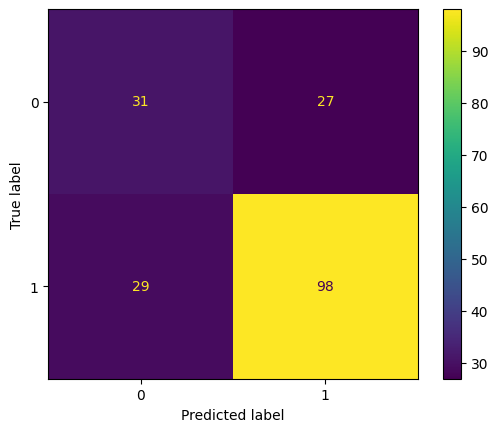

In [705]:
cm = confusion_matrix(y_test_pt.numpy(), predicted.numpy())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='viridis')
plt.show()

In [707]:
train_correct = 0
train_total = 0
for x_batch, y_batch in train_dl:
    probas = model2(x_batch)
    _, predicted_train = torch.max(probas.data, 1)
    train_correct += (predicted_train == y_batch).sum().item()
    train_total += y_batch.size(0)

train_acc = 100 * train_correct / train_total
print(f"Train Acc: {train_acc:.2f}, Test Acc: {100 * correct / total:.2f}")
print(classification_report(y_test_np, predicted_np))

Train Acc: 79.52, Test Acc: 69.73
              precision    recall  f1-score   support

         0.0       0.52      0.53      0.53        58
         1.0       0.78      0.77      0.78       127

    accuracy                           0.70       185
   macro avg       0.65      0.65      0.65       185
weighted avg       0.70      0.70      0.70       185

